In [141]:
# IMPORTS

import imageio
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import torch.optim as optim
import torchvision
import cv2
from skimage.restoration import denoise_tv_bregman
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from torchvision.utils import make_grid
import math
from zipfile import ZipFile
from google.colab import drive
from tqdm import tqdm
import os
import torchvision

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
preprocess_steps = transforms.Compose([
    transforms.CenterCrop(227),
    transforms.ToTensor(),
])

In [ ]:
entries = os.listdir("drive/MyDrive/cinema")
imgs = []
for entry in tqdm(entries[:-1]):
  img = preprocess_steps(Image.open("drive/MyDrive/cinema/"+ entry))
  if img.shape[0]==3:
    imgs.append(img) 
imgs = torch.stack(imgs)

100%|██████████| 1299/1299 [00:14<00:00, 91.00it/s] 


In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(    
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5),
            nn.Conv2d(96, 256, kernel_size=5, padding=2, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(9216, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


model = AlexNet()
model.load_state_dict(torch.load("drive/MyDrive/net.pt"))
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (11): ReLU(inplace=True)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear

In [ ]:
class SaveFeatures:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
    def close(self):
        self.hook.remove()

activations = SaveFeatures(model.classifier[-4])

In [ ]:
mean = torch.tensor([123., 117., 104.])/255
all_activations = []
for input_image in imgs:
  image = input_image - mean[:, None, None]
  model(image.unsqueeze(0))
  all_activations.append(activations.features[0].detach());

all_activations = torch.stack(all_activations, 0).numpy()


In [ ]:
k = 10
pca = PCA(n_components=50)
res = pca.fit_transform(all_activations)
X_embedded = TSNE(n_components=2).fit_transform(res)
kmeans = KMeans(n_clusters=k, n_init=k).fit(X_embedded)
labels = kmeans.labels_

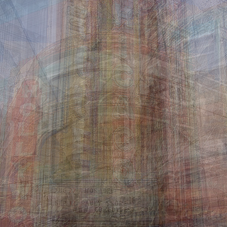

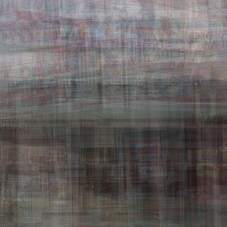

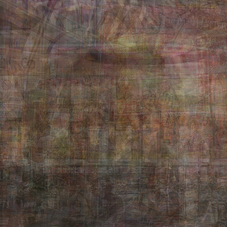

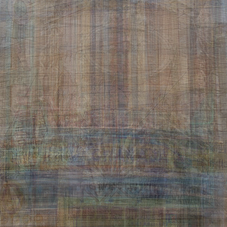

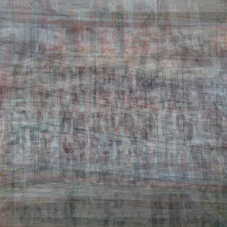

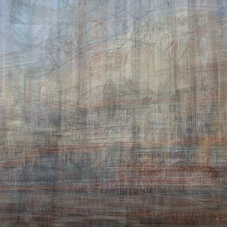

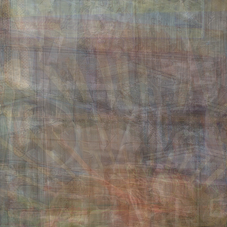

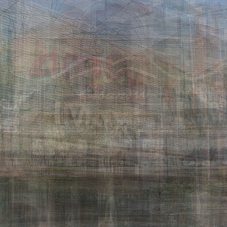

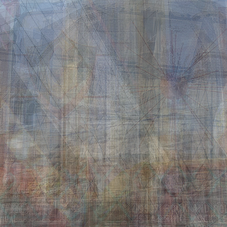

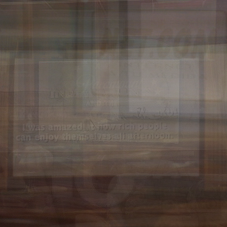

In [ ]:
for claster in range(k):
  img_id2distance = {}
  cl_center_coord = kmeans.cluster_centers_[claster]
  for idx, is_claster in enumerate(labels==claster):
    if (is_claster):
      img_id2distance[idx] = math.dist(cl_center_coord, X_embedded[idx])

  closest_coord_idx = [idx for idx, _ in sorted(img_id2distance.items(), key=lambda x:x[1])[:15]]

  mean_img = torch.mean(torch.stack([imgs[i].permute(1, 2, 0) for i in closest_coord_idx]), dim=0)
  mean_img = Image.fromarray(np.array(mean_img*255).astype(np.uint8))
  mean_img.show()
  mean_img.save(f'mean_{claster+1}.jpg')

In [ ]:
def class_show(images):
  plt.figure(figsize=(10, 10))
  plt.imshow(make_grid((images * 255).int(), padding=1, pad_value=255).permute(1, 2, 0).cpu())
  _ = plt.axis('off')

def generate_images(label):
  return torch.stack([imgs[i] for i, l in enumerate(labels) if (l==label)])

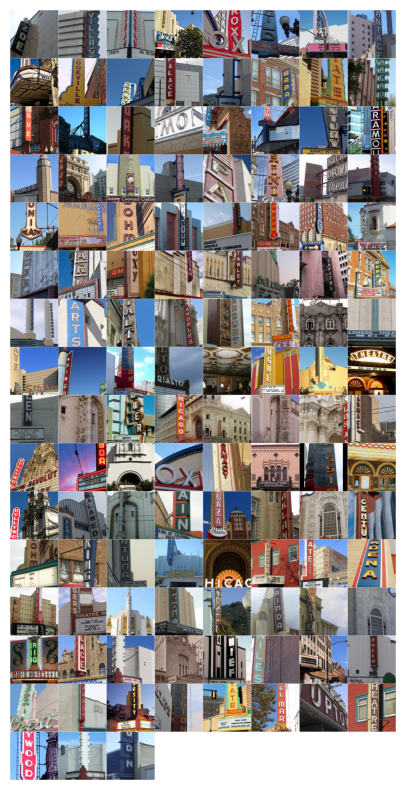

In [ ]:
class_show(generate_images(label=0))

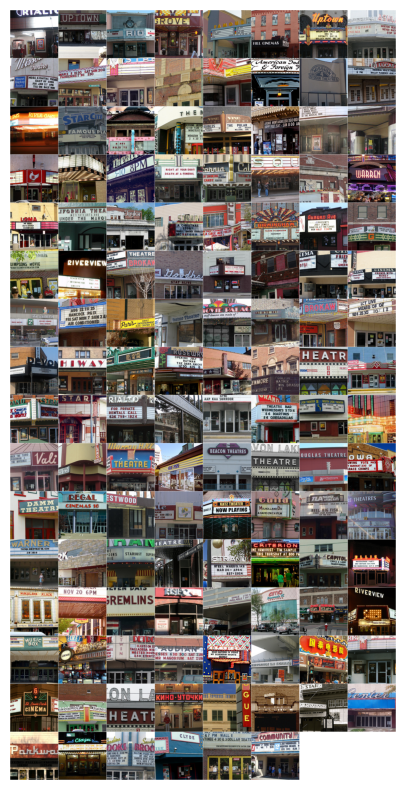

In [ ]:
class_show(generate_images(label=1))

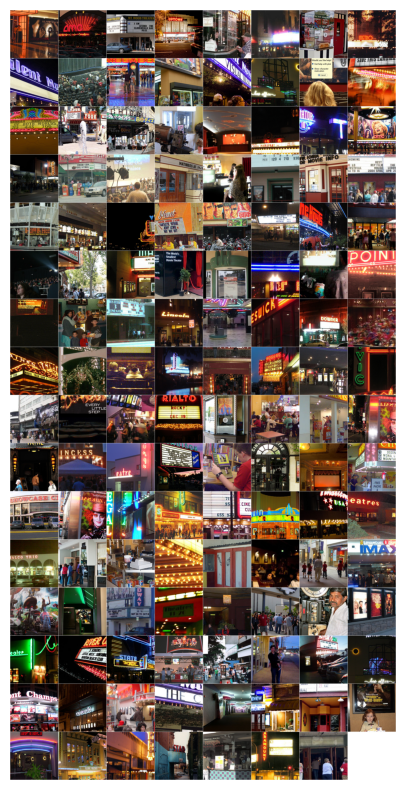

In [ ]:
class_show(generate_images(label=2))